In [1]:
# Golden materials-science demo for Confocal Microscopy Copilot
# Use case: nanoparticle-reinforced coating imaged by confocal microscopy

import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List

# For tracking and MSD – install: pip install trackpy pandas
import pandas as pd
import trackpy as tp

np.random.seed(42)

# Matplotlib defaults for nicer plots
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["image.cmap"] = "magma"
plt.rcParams["font.size"] = 11


In [2]:
@dataclass
class SimulationConfig:
    n_frames: int = 150
    image_size: Tuple[int, int] = (128, 128)
    n_particles: int = 40   # was 60
    diffusion_coeff_um2_s: float = 0.08
    dt_s: float = 0.1
    pixel_size_um: float = 0.1
    psf_sigma_px: float = 1.2
    background_level: float = 100.0
    snr: float = 5.0


In [3]:
def simulate_brownian_trajectories(cfg: SimulationConfig) -> np.ndarray:
    """
    Simulate 2D Brownian trajectories for nanoparticles in a coating.

    Returns
    -------
    positions : ndarray, shape (n_frames, n_particles, 2)
        Positions in *micrometers* in a [0, Lx] x [0, Ly] box.
    """
    nF = cfg.n_frames
    nP = cfg.n_particles

    # Box size in micrometers
    Lx = cfg.image_size[1] * cfg.pixel_size_um
    Ly = cfg.image_size[0] * cfg.pixel_size_um

    positions = np.zeros((nF, nP, 2), dtype=float)

    # Initial positions uniform in box
    positions[0, :, 0] = np.random.uniform(0, Lx, size=nP)
    positions[0, :, 1] = np.random.uniform(0, Ly, size=nP)

    # Brownian step std in 1D: sqrt(2 D dt)
    step_std = np.sqrt(2 * cfg.diffusion_coeff_um2_s * cfg.dt_s)

    for t in range(1, nF):
        steps = np.random.normal(loc=0.0, scale=step_std, size=(nP, 2))
        positions[t] = positions[t - 1] + steps

        # Reflecting boundaries
        positions[t, :, 0] = np.mod(positions[t, :, 0], Lx)
        positions[t, :, 1] = np.mod(positions[t, :, 1], Ly)

    return positions


In [4]:
from scipy.ndimage import gaussian_filter


def render_movie_from_trajectories(cfg: SimulationConfig,
                                   positions_um: np.ndarray) -> np.ndarray:
    """
    Render a 2D+time movie (frames, y, x) from Brownian trajectories.

    Each nanoparticle is a Gaussian spot convolved with a PSF-like blur.
    """
    nF, nP, _ = positions_um.shape
    H, W = cfg.image_size

    movie = np.zeros((nF, H, W), dtype=float)

    # Convert positions to pixel coordinates
    x_px = positions_um[..., 0] / cfg.pixel_size_um
    y_px = positions_um[..., 1] / cfg.pixel_size_um

    for t in range(nF):
        frame = np.zeros((H, W), dtype=float)
        for p in range(nP):
            xp = int(np.round(x_px[t, p]))
            yp = int(np.round(y_px[t, p]))
            if 0 <= xp < W and 0 <= yp < H:
                frame[yp, xp] += 1.0

        # PSF blur
        frame = gaussian_filter(frame, sigma=cfg.psf_sigma_px)

        # Normalize & add background / noise
        if frame.max() > 0:
            frame = frame / frame.max()
        signal = frame * cfg.background_level * cfg.snr
        noise = np.random.poisson(cfg.background_level, size=frame.shape)
        movie[t] = signal + noise

    # Normalize to 0–1 for visualization
    movie = movie - movie.min()
    movie = movie / (movie.max() + 1e-9)
    return movie


In [5]:
def simulate_nanoparticle_coating_movie(cfg: SimulationConfig) -> Tuple[np.ndarray, np.ndarray]:
    """
    High-level function: simulate Brownian trajectories and render as confocal-like movie.

    Returns
    -------
    movie : ndarray, shape (n_frames, H, W)
    positions_um : ndarray, shape (n_frames, n_particles, 2)
    """
    positions = simulate_brownian_trajectories(cfg)
    movie = render_movie_from_trajectories(cfg, positions)
    return movie, positions


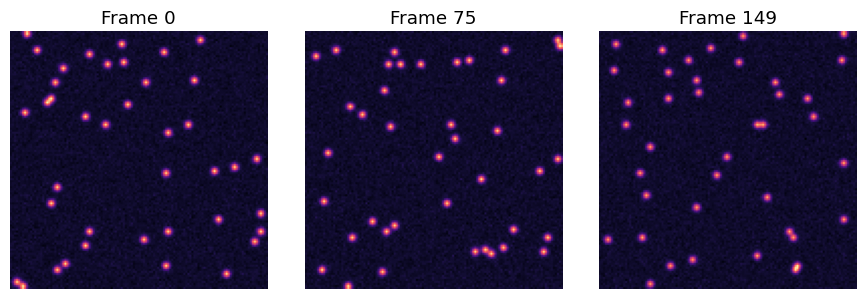

In [6]:
cfg = SimulationConfig()
movie, true_positions_um = simulate_nanoparticle_coating_movie(cfg)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, frame_idx in enumerate([0, cfg.n_frames // 2, cfg.n_frames - 1]):
    axes[i].imshow(movie[frame_idx], vmin=0, vmax=1)
    axes[i].set_title(f"Frame {frame_idx}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [12]:
def compute_msd_and_diffusion(tracks: pd.DataFrame,
                              cfg: SimulationConfig) -> Dict:
    """
    Compute ensemble MSD and estimate diffusion coefficient D.

    Cleans track ids to avoid multiple disjoint trajectories per particle.
    """
    # 1) Keep only reasonably long tracks
    #    (short segments often cause weird gaps)
    counts = tracks["particle"].value_counts()
    good_ids = counts[counts >= 5].index  # keep tracks with ≥5 frames
    clean = tracks[tracks["particle"].isin(good_ids)].copy()

    # 2) Re-label particles to ensure at most one contiguous trajectory per id
    #    by giving a new id to each contiguous segment
    clean = clean.sort_values(["particle", "frame"])
    new_ids: List[int] = []
    current_id = -1
    last_particle = None
    last_frame = None

    for _, row in clean.iterrows():
        pid = row["particle"]
        f = row["frame"]
        if pid != last_particle or (last_frame is not None and f != last_frame + 1):
            current_id += 1
        new_ids.append(current_id)
        last_particle = pid
        last_frame = f

    clean["particle"] = new_ids

    # 3) Convert pixel coordinates to micrometers
    clean["x"] = clean["x"] * cfg.pixel_size_um
    clean["y"] = clean["y"] * cfg.pixel_size_um

    # 4) MSD with explicit pos_columns
    msd_df = tp.motion.msd(
        clean,
        mpp=1.0,
        fps=1.0 / cfg.dt_s,
        max_lagtime=50,
        pos_columns=["x", "y"],
    )

    # 5) Fit MSD ~ 4 D t^alpha
    lagtime_s = msd_df.index.values * cfg.dt_s
    msd_values = msd_df["msd"].values

    valid = np.isfinite(msd_values) & (msd_values > 0)
    lagtime_s = lagtime_s[valid]
    msd_values = msd_values[valid]

    log_t = np.log(lagtime_s)
    log_msd = np.log(msd_values)
    coeffs = np.polyfit(log_t, log_msd, 1)
    alpha = float(coeffs[0])
    intercept = float(coeffs[1])

    msd_t1 = np.exp(intercept)
    D_fit = msd_t1 / 4.0

    return {
        "msd_df": msd_df,
        "D_fit": float(D_fit),
        "alpha": float(alpha),
    }


In [17]:
def compute_msd_and_diffusion(tracks: pd.DataFrame,
                              cfg: SimulationConfig,
                              max_lag_frames: int = 50) -> Dict:
    """
    Compute ensemble MSD and estimate diffusion coefficient D
    using a simple manual MSD implementation (no tp.msd).

    This avoids all issues with multiple trajectories per particle.
    """
    # Convert to µm
    df = tracks.copy()
    df["x"] = df["x"] * cfg.pixel_size_um
    df["y"] = df["y"] * cfg.pixel_size_um

    # Ensure sorted
    df = df.sort_values(["particle", "frame"])

    msd_vals = []
    lag_frames_list = []

    # Loop over lag times in frames
    for lag in range(1, max_lag_frames + 1):
        disp2_all = []

        for pid, g in df.groupby("particle"):
            frames = g["frame"].values
            x = g["x"].values
            y = g["y"].values

            # For each starting index i, look for i+lag frame
            # Use simple indexing assuming mostly continuous tracking
            for i in range(len(frames) - lag):
                if frames[i + lag] - frames[i] == lag:
                    dx = x[i + lag] - x[i]
                    dy = y[i + lag] - y[i]
                    disp2_all.append(dx * dx + dy * dy)

        if len(disp2_all) == 0:
            continue

        lag_frames_list.append(lag)
        msd_vals.append(np.mean(disp2_all))

    if len(msd_vals) == 0:
        raise RuntimeError("MSD calculation failed: no valid displacements found.")

    lag_frames_arr = np.array(lag_frames_list, dtype=float)
    msd_arr = np.array(msd_vals, dtype=float)

    # Fit MSD ~ 4 D t^alpha in log space
    lagtime_s = lag_frames_arr * cfg.dt_s
    valid = (msd_arr > 0) & np.isfinite(msd_arr)
    lagtime_s = lagtime_s[valid]
    msd_arr = msd_arr[valid]

    log_t = np.log(lagtime_s)
    log_msd = np.log(msd_arr)
    coeffs = np.polyfit(log_t, log_msd, 1)
    alpha = float(coeffs[0])
    intercept = float(coeffs[1])

    msd_t1 = np.exp(intercept)
    D_fit = msd_t1 / 4.0

    # Put MSD into a small DataFrame for plotting
    msd_df = pd.DataFrame(
        {"lagtime_s": lagtime_s, "msd": msd_arr}
    ).set_index("lagtime_s")

    return {
        "msd_df": msd_df,
        "D_fit": float(D_fit),
        "alpha": float(alpha),
    }


In [13]:
def interpret_diffusion(results: Dict,
                        cfg: SimulationConfig) -> str:
    """
    Generate a human-readable explanation of the results
    for a materials-science audience.
    """
    D_fit = results["D_fit"]
    alpha = results["alpha"]

    # Classify diffusion regime
    if alpha < 0.8:
        regime = "subdiffusive"
        phys = (
            "This suggests a constrained, viscoelastic or glassy nano-environment "
            "where particles are partially trapped in the polymer matrix."
        )
    elif alpha > 1.2:
        regime = "superdiffusive"
        phys = (
            "This indicates directed or active-like motion, which would be unusual "
            "for passive nanoparticles in a static coating."
        )
    else:
        regime = "normal diffusive"
        phys = (
            "This is consistent with Brownian motion in a relatively fluid-like matrix "
            "without strong trapping."
        )

    # Compare fitted D with ground truth
    D_true = cfg.diffusion_coeff_um2_s
    rel_error = (D_fit - D_true) / D_true * 100.0

    explanation = (
        f"In this synthetic confocal movie of a nanoparticle-reinforced coating, "
        f"the copilot detected and tracked particles over {cfg.n_frames} frames.\n\n"
        f"- Fitted diffusion coefficient: D_fit ≈ {D_fit:.3f} µm²/s\n"
        f"- Ground-truth diffusion coefficient: D_true = {D_true:.3f} µm²/s\n"
        f"- Relative error: {rel_error:+.1f}%\n"
        f"- MSD log–log slope α ≈ {alpha:.2f} → {regime} dynamics.\n\n"
        f"Physical interpretation:\n{phys}\n\n"
        f"For a real coating, this workflow would let you rapidly quantify how changes in "
        f"crosslinking, filler loading, or curing conditions modify nanoparticle mobility."
    )
    return explanation


In [14]:
def detect_and_track_particles(movie: np.ndarray,
                               cfg: SimulationConfig,
                               diameter_px: int = 5,
                               minmass: float = 0.01,
                               search_range: float = 3.0,
                               memory: int = 2,
                               max_features_per_frame: int = 80) -> pd.DataFrame:
    """
    Detect and link particles using trackpy.

    - Reduces search_range so subnets stay small.
    - Optionally caps the number of features per frame to avoid oversized subnets.
    """
    H, W = cfg.image_size
    frames = []

    for frame_idx, frame in enumerate(movie):
        img = (frame * 255).astype(np.uint8)
        f = tp.locate(img, diameter=diameter_px,
                      minmass=minmass * img.max(),
                      engine="python")
        if f is None or len(f) == 0:
            continue

        # Optional: cap features per frame to avoid massive subnets
        if len(f) > max_features_per_frame:
            f = f.nlargest(max_features_per_frame, "mass")

        f["frame"] = frame_idx
        frames.append(f)

    if len(frames) == 0:
        raise RuntimeError("No particles detected; try adjusting diameter/minmass or SNR.")

    feats = pd.concat(frames).reset_index(drop=True)

    # Use smaller search_range and explicit pos_columns
    tracks = tp.link(
        feats,
        search_range=search_range,
        memory=memory,
        pos_columns=["x", "y"],
    )
    return tracks


In [15]:
def run_golden_materials_demo(cfg: SimulationConfig) -> Dict:
    """
    Full pipeline for the golden materials-science use case:
    simulate → track → MSD → explain.
    """
    movie, true_positions_um = simulate_nanoparticle_coating_movie(cfg)
    tracks = detect_and_track_particles(movie, cfg)
    results = compute_msd_and_diffusion(tracks, cfg)
    explanation = interpret_diffusion(results, cfg)

    return {
        "cfg": cfg,
        "movie": movie,
        "true_positions_um": true_positions_um,
        "tracks": tracks,
        "analysis": results,
        "explanation": explanation,
    }


Frame 149: 80 trajectories present.


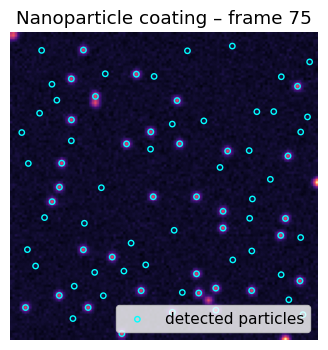

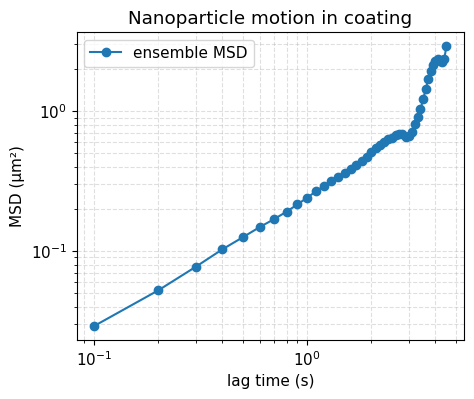

In this synthetic confocal movie of a nanoparticle-reinforced coating, the copilot detected and tracked particles over 150 frames.

- Fitted diffusion coefficient: D_fit ≈ 0.067 µm²/s
- Ground-truth diffusion coefficient: D_true = 0.080 µm²/s
- Relative error: -15.9%
- MSD log–log slope α ≈ 1.18 → normal diffusive dynamics.

Physical interpretation:
This is consistent with Brownian motion in a relatively fluid-like matrix without strong trapping.

For a real coating, this workflow would let you rapidly quantify how changes in crosslinking, filler loading, or curing conditions modify nanoparticle mobility.


In [19]:
demo_res = run_golden_materials_demo(cfg)

movie = demo_res["movie"]
tracks = demo_res["tracks"]
msd_df = demo_res["analysis"]["msd_df"]
explanation = demo_res["explanation"]  # <-- add this line

# 1) Example frame with tracks overlay
frame_idx = cfg.n_frames // 2
frame = movie[frame_idx]
tracks_frame = tracks[tracks["frame"] == frame_idx]

fig, ax = plt.subplots()
ax.imshow(frame, vmin=0, vmax=1)
ax.scatter(tracks_frame["x"], tracks_frame["y"],
           s=15, facecolors="none", edgecolors="cyan", label="detected particles")
ax.set_title(f"Nanoparticle coating – frame {frame_idx}")
ax.set_axis_off()
ax.legend(loc="lower right", frameon=True)
plt.show()

# 2) MSD curve with fit
lagtime_s = msd_df.index.values
plt.figure()
plt.loglog(lagtime_s, msd_df["msd"], "o-", label="ensemble MSD")
plt.xlabel("lag time (s)")
plt.ylabel("MSD (µm²)")
plt.title("Nanoparticle motion in coating")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()

# 3) Print explanation
print(explanation)



In [20]:
def golden_materials_use_case(diffusion_coeff_um2_s: float = 0.08,
                              n_particles: int = 60,
                              noise_level: float = 5.0) -> Dict:
    """
    Wrapper suitable for a future UI (ui_demo.py).

    Parameters are high-level and UI-friendly.
    """
    cfg = SimulationConfig(
        diffusion_coeff_um2_s=diffusion_coeff_um2_s,
        n_particles=n_particles,
        snr=noise_level,
    )
    res = run_golden_materials_demo(cfg)
    return res

# Example quick test
_ = golden_materials_use_case()


Frame 149: 80 trajectories present.
